# Enhanced Zero-shot Learning with Neuron-concepts

In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np  

In [2]:
from data_utils import get_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "cvcl"
model, preprocess = get_model(model_name, device)
layers = "vision_encoder.model.layer1,vision_encoder.model.layer2,vision_encoder.model.layer3,vision_encoder.model.layer4"
layers = layers.split(",")  
# data = get_dataset('awa2', preprocess, "classes.txt", baby_vocab=False, get_attr=False)
# dataloader = DataLoader(data, batch_size=512, shuffle=False, num_workers=4)

Loading CVCL...
Invalid backbone, set to resnext50


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`


Successfully loaded CVCL-resnext50


/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.


## Register Hooks

In [3]:
from utils import get_activation

def per_img_activations(model, model_name, layers, dataset, batch_size, device='cuda', pool_mode='avg'):

    all_features = {layer: [] for layer in layers}
    hooks = {}

    # register forward hook
    for layer in layers:
        module = dict(model.named_modules()).get(layer)
        if module:
            hooks[layer] = module.register_forward_hook(get_activation(all_features[layer], pool_mode))
            print(f"Hook registered for layer: {layer}")
        else:
            print(f"Warning: Layer '{layer}' does not exist in the model.")

    # Forward pass
    with torch.no_grad():
        for images in tqdm(DataLoader(dataset, batch_size, num_workers=8, pin_memory=True)):
            if "cvcl" in model_name:
                _ = model.encode_image(images.to(device))
            else:
                _ = model(images.to(device))

    # Remove 
    for layer in layers:
        hooks[layer].remove()

    torch.cuda.empty_cache()
    print("Activations saved and memory cleaned up.")

    # dict: {layername: activation tensor[batch_size, n_neurons]}
    activations = {layer: torch.stack(all_features[layer]) for layer in layers}

    return activations

Load Image

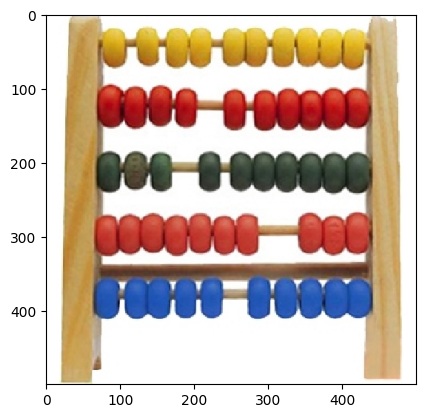

In [26]:
import matplotlib.pyplot as plt
img = Image.open('/home/Dataset/xueyi/KonkleLab/17-objects/abacus/bg-abacus.jpg')
data = torch.unsqueeze(preprocess(img), 0)
plt.imshow(img)

Get activation


In [27]:
activations = per_img_activations(model=model, model_name=model_name, layers=layers, dataset=data, batch_size=200, device=device)

print(activations['vision_encoder.model.layer1'].shape,
      activations['vision_encoder.model.layer2'].shape,
      activations['vision_encoder.model.layer3'].shape,
      activations['vision_encoder.model.layer4'].shape,)

Hook registered for layer: vision_encoder.model.layer1
Hook registered for layer: vision_encoder.model.layer2
Hook registered for layer: vision_encoder.model.layer3
Hook registered for layer: vision_encoder.model.layer4


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

Activations saved and memory cleaned up.
torch.Size([1, 1, 256]) torch.Size([1, 1, 512]) torch.Size([1, 1, 1024]) torch.Size([1, 1, 2048])


Find Top-k activationa and index

In [6]:
activations['vision_encoder.model.layer4'].min(), activations['vision_encoder.model.layer4'].max()

(tensor(0., device='cuda:0'), tensor(3.2592, device='cuda:0'))

Layer vision_encoder.model.layer1 has 3 units with activations > 1
Layer vision_encoder.model.layer2 has 3 units with activations > 1
Layer vision_encoder.model.layer3 has 3 units with activations > 1
Layer vision_encoder.model.layer4 has 3 units with activations > 1


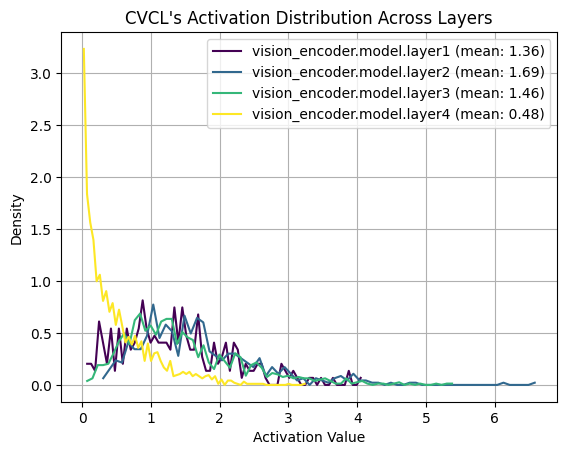

In [7]:

# Assuming 'activations' is your dictionary of activation tensors
threshold = 1  # Set threshold
activated_units = {}  # Dictionary to store indices of units with activation above threshold

colors = plt.cm.viridis(np.linspace(0, 1, len(activations)))  # Color map for plotting

for i, (layer, activation_tensor) in enumerate(activations.items()):
    # Ensure tensor is on CPU and flatten it for histogram calculation
    activations_array = activation_tensor.cpu().numpy().flatten()

    # Compute histogram data
    values, base = np.histogram(activations_array, bins=70, density=True)
    # Calculate mid points for histogram bins
    mid_points = 0.5 * (base[:-1] + base[1:])

    # Print information about activated units
    mask = activation_tensor > threshold
    indices = np.nonzero(mask)
    activated_units[layer] = indices
    print(f"Layer {layer} has {len(indices[0])} units with activations > {threshold}")

    # Plot histogram with the specified color
    plt.plot(mid_points, values, color=colors[i], label=f'{layer} (mean: {activations_array.mean():.2f})')

plt.legend()
plt.title('CVCL\'s Activation Distribution Across Layers')
plt.xlabel('Activation Value')
plt.ylabel('Density')
plt.grid(True)

# Show the plot
plt.show()

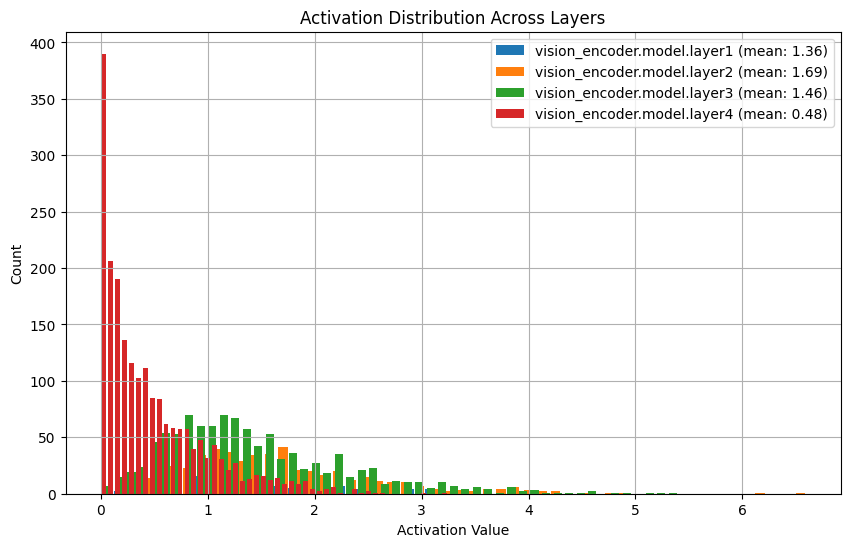

In [8]:

# 设定图形大小和分辨率
plt.figure(figsize=(10, 6))

# 遍历每层，计算激活值的直方图并绘制
for layer, activation_tensor in activations.items():
    # 将张量转换为numpy数组并展平
    activations_array = activation_tensor.cpu().numpy().flatten()

    # 计算直方图数据
    values, base = np.histogram(activations_array, bins=50)
    # 计算宽度
    width = (base[1] - base[0]) * 0.7

    # 绘制条形图
    plt.bar(base[:-1], values, width=width, label=f'{layer} (mean: {activations_array.mean():.2f})', align='edge')

# 添加图例
plt.legend()
plt.title('Activation Distribution Across Layers')
plt.xlabel('Activation Value')
plt.ylabel('Count')
plt.grid(True)

# 展示图形
plt.show()

In [9]:
import os
import json

def get_category_names(directory, valid_keys):
    category_names = []
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            if item in valid_keys:  # 过滤操作
                category_names.append(item)
    return category_names

def load_vocab(vocab_path):
    with open(vocab_path, 'r') as file:
        vocab = json.load(file)
    return set(vocab.keys())

vocab_path = "/home/xke001/demo/zero-shot/multimodal/vocab.json"
valid_keys = load_vocab(vocab_path)

directory_path = '/home/Dataset/xueyi/KonkleLab/17-objects/'
categories = get_category_names(directory_path, valid_keys)
print(categories)
print(len(categories))

['crib', 'knife', 'necklace', 'clock', 'cake', 'bottle', 'pizza', 'toothpaste', 'backpack', 'ring', 'fan', 'cookie', 'scissors', 'socks', 'hat', 'spoon', 'stamp', 'watch', 'broom', 'bell', 'phone', 'umbrella', 'train', 'rock', 'airplane', 'ball', 'juice', 'bird', 'bucket', 'bowl', 'button', 'sofa', 'coin', 'pants', 'pen', 'tv', 'key', 'cheese', 'chair', 'guitar', 'kayak', 'shoe', 'bagel', 'leaves', 'bike', 'stool', 'camera', 'dog', 'turtle', 'desk', 'hairbrush', 'pipe', 'bed', 'balloon', 'basket', 'bench', 'sandwich', 'butterfly', 'tree', 'microwave', 'jacket', 'cat', 'apple', 'tricycle']
64


Find Zero-shot Description

In [28]:


def compute_alignment_values(df_desc, activation_dict):
    data = []
    
    for _, row in df_desc.iterrows():
        layer, unit, similarity= row['layer'], row['unit'], row['similarity']
        activation = activation_dict[layer][:,:, unit].cpu().numpy().squeeze()
        # calculate alignment value
        alignment_value = similarity * activation
        
        data.append((layer, unit, row['description'], float(similarity), float(activation), float(alignment_value)))
        
    df = pd.DataFrame(data, columns=['layer', 'unit', 'description', 'similarity', 'activation', 'alignment_value'])
    
    # 'alignment_value', 'activation' or 'similarity'
    # df.sort_values(by=sort_by, ascending=False, inplace=True)
    return df

df_desc = pd.read_csv('neuron_concept/cvcl_broden_broden.csv')


df = compute_alignment_values(df_desc, activations)

# 打印每一层的top 5

sort_by = 'activation'
for layer in df['layer'].unique():
    top_records = df[df['layer'] == layer].nlargest(5, sort_by)[['layer', 'unit', 'description', sort_by]]
    print(f"Top 5 for {layer}:\n{top_records}\n")

Top 5 for vision_encoder.model.layer1:
                           layer  unit    description  activation
172  vision_encoder.model.layer1   172      place mat    3.737802
56   vision_encoder.model.layer1    56  skittle alley    3.720430
134  vision_encoder.model.layer1   134      sprinkled    3.175739
44   vision_encoder.model.layer1    44   polka-dotted    3.103382
35   vision_encoder.model.layer1    35           grid    3.015823

Top 5 for vision_encoder.model.layer2:
                           layer  unit          description  activation
572  vision_encoder.model.layer2   316              paisley    5.726617
748  vision_encoder.model.layer2   492              paisley    5.174815
695  vision_encoder.model.layer2   439              paisley    4.284125
453  vision_encoder.model.layer2   197  circus tent-outdoor    4.233546
547  vision_encoder.model.layer2   291           interlaced    4.202687

Top 5 for vision_encoder.model.layer3:
                            layer  unit             d

In [11]:
top_records_df = pd.DataFrame()

# Loop through each unique layer and find the top 5 records based on 'alignment_value'
for layer in df['layer'].unique():
    top_5 = df[df['layer'] == layer].nlargest(5, 'alignment_value')[['layer', 'unit', 'description', 'alignment_value']]
    top_records_df = pd.concat([top_records_df, top_5])

# Reset the index for better formatting
top_records_df.reset_index(drop=True, inplace=True)
top_records_df.to_excel('output.xlsx', index=False)
# Display the DataFrame
print(top_records_df)

                          layer  unit description  alignment_value
0   vision_encoder.model.layer1   245    scissors         8.229822
1   vision_encoder.model.layer1    35       broom         6.404340
2   vision_encoder.model.layer1    56      yellow         6.314678
3   vision_encoder.model.layer1    25       broom         5.835096
4   vision_encoder.model.layer1    48         red         5.753521
5   vision_encoder.model.layer2    86       broom        13.194166
6   vision_encoder.model.layer2    19    scissors         9.180209
7   vision_encoder.model.layer2   355         pen         8.840083
8   vision_encoder.model.layer2    79    scissors         8.524939
9   vision_encoder.model.layer2   138       broom         8.195519
10  vision_encoder.model.layer3   186       broom        12.208515
11  vision_encoder.model.layer3    77       broom        11.805857
12  vision_encoder.model.layer3   635    necklace        10.224978
13  vision_encoder.model.layer3   812         pen         9.90

In [15]:

# net-dissect 
def compute_alignment_values(df_desc, activation_dict):
    # 暂存每一层的alignment values
    layer_data = {}
    
    for _, row in df_desc.iterrows():
        layer = row['layer']
        unit = row['unit']
        similarity = row['score']
        activation = activation_dict[layer][:,:,unit].cpu().numpy().squeeze()  # 确保激活值是一维数组
        
        alignment_value = similarity * activation
        layer_data.setdefault(layer, []).append((unit, row['label'], alignment_value))
    
    # 更新DataFrame
    for layer, values in layer_data.items():
        sorted_values = sorted(values, key=lambda x: x[2], reverse=True)  # 对alignment value排序
        units, descriptions, alignments = zip(*sorted_values)
        
        layer_indices = df_desc[df_desc['layer'] == layer].index
        min_length = min(len(layer_indices), len(units))
        df_desc.loc[layer_indices[:min_length], 'unit'] = units[:min_length]
        df_desc.loc[layer_indices[:min_length], 'label'] = descriptions[:min_length]
        df_desc.loc[layer_indices[:min_length], 'alignment_value'] = np.array(alignments)[:min_length]

    df_desc['alignment_value'] = df_desc['alignment_value'].astype(float)

# 加载数据和activation字典
df = pd.read_csv('neuron_concept/netdis_cvcl_005.csv')
standardized_activation_dict = {}
for key, value in activations.items():
    standard_key = key.split('.')[-1]  # 取最后一个点后的部分作为key
    standardized_activation_dict[standard_key] = value

compute_alignment_values(df, standardized_activation_dict)

top_records_df = pd.DataFrame()

# Loop through each unique layer and find the top 5 records based on 'alignment_value'
for layer in df['layer'].unique():
    top_5 = df[df['layer'] == layer].nlargest(5, 'alignment_value')[['layer', 'unit', 'label', 'alignment_value']]
    top_records_df = pd.concat([top_records_df, top_5])

# Reset the index for better formatting
top_records_df.reset_index(drop=True, inplace=True)
top_records_df.to_excel('output.xlsx', index=False)
# Display the DataFrame
print(top_records_df)

KeyError: 'similarity'

In [29]:
def compute_alignment_values_broden(df_desc, activation_dict):
    data = []
    standardized_activation_dict = {key.split('.')[-1]: value for key, value in activation_dict.items()}

    for _, row in df_desc.iterrows():
        layer, unit, similarity= row['layer'], row['unit'], row['score']
        activation = standardized_activation_dict[layer][:,:, unit].cpu().numpy().squeeze()
        # calculate alignment value
        alignment_value = similarity * activation
        
        data.append((layer, unit, row['label'], float(similarity), float(activation), float(alignment_value)))
        
    df = pd.DataFrame(data, columns=['layer', 'unit', 'description', 'score', 'activation', 'alignment_value'])
    
    # 'alignment_value', 'activation' or 'similarity'
    # df.sort_values(by=sort_by, ascending=False, inplace=True)
    return df
    
df_desc = pd.read_csv('neuron_concept/netdis_cvcl_005.csv')


df = compute_alignment_values_broden(df_desc, activations)

# 打印每一层的top 5
for layer in df['layer'].unique():
    top_records = df[df['layer'] == layer].nlargest(5, 'alignment_value')[['layer', 'unit', 'description', 'activation','alignment_value']]
    print(f"Top 5 for {layer}:\n{top_records}\n")

Top 5 for layer1:
      layer  unit description  activation  alignment_value
48   layer1    48       red-c    2.985082         0.178523
190  layer1   190     white-c    2.234323         0.080173
16   layer1    16    yellow-c    1.868439         0.075760
56   layer1    56    yellow-c    3.720430         0.064582
35   layer1    35     white-c    3.015823         0.061593

Top 5 for layer2:
      layer  unit description  activation  alignment_value
299  layer2    43     white-c    3.745518         0.073463
296  layer2    40     white-c    4.033981         0.068404
485  layer2   229     white-c    3.864950         0.063976
394  layer2   138     white-c    2.346098         0.063557
572  layer2   316     white-c    5.726617         0.057975

Top 5 for layer3:
       layer  unit description  activation  alignment_value
1011  layer3   243      dotted    4.844228         0.184851
1543  layer3   775      dotted    5.580495         0.121690
1214  layer3   446   chequered    8.049244         0.112

Normed Activation * Similairty